In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")
import numpy as np

In [2]:
filename = {"MINERvA":"MINERvA_Dipole_M4.70e-01_mu2.50e-06_example.parquet",
            "MiniBooNE":"MiniBooNE_Dipole_M4.70e-01_mu2.50e-06_example.parquet",
            "CCM":"CCM_Dipole_M2.35e-02_mu6.00e-07_example.parquet"}

POT = {"MINERvA":12.2e20,
       "MiniBooNE":18.75e20,
       "CCM":2.25e22}

Emax = {"MINERvA":20,
        "MiniBooNE":5,
        "CCM":0.04}

axis = {"MINERvA":3,
        "MiniBooNE":3,
        "CCM":1}

xrange = {"MINERvA":[-1.5,1.5],
          "MiniBooNE":[-8,8],
          "CCM":[-25,3]}

yrange = {"MINERvA":[-1.5,1.5],
          "MiniBooNE":[-8,8],
          "CCM":[-10,10]}

zrange = {"MINERvA":[-10,6],
          "MiniBooNE":[-8,8],
          "CCM":[-5,5]}

ylim_E = {"MINERvA":[1e1,9e5],
          "MiniBooNE":[1e0,1e4],
          "CCM":[1e-3,1e6]}

ylim_C = {"MINERvA":[1e1,5e6],
          "MiniBooNE":[1e-1,1e5],
          "CCM":[1e-3,1e6]}


In [3]:
# Kinematic distributions

def plot_kinematics(data,POT,Emax,axis,ylim_E=None,ylim_C=None,nbins=30,savestr=None):
    
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    ax[1].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    
    dec_flag = data["primary_type"]=="ParticleType.N4"
    fid_flag = data["in_fiducial"][dec_flag]
    
    # initial nu
    nu_flag = data["primary_type"]=="ParticleType.NuMu"
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

    # N
    N_flag = data["primary_type"]=="ParticleType.N4"
    N_momenta = np.squeeze(data["primary_momentum"][N_flag])

    # gamma
    gamma_flag = data["secondary_types"]=='ParticleType.Gamma'
    gamma_momenta = data["secondary_momenta"][gamma_flag]
    # mask out entries that are not gamma
    gamma_momenta = awk.mask(gamma_momenta, awk.num(gamma_momenta,axis=2)>0)
    gamma_momenta = np.squeeze(gamma_momenta[~awk.is_none(gamma_momenta,axis=1)])
    
    # nu out
    nuout_flag = data["secondary_types"]=='ParticleType.NuLight'
    nuout_momenta = data["secondary_momenta"][nuout_flag]
    # mask out entries that are not nuout
    nuout_momenta = awk.mask(nuout_momenta, awk.num(nuout_momenta,axis=2)>0)
    nuout_momenta = np.squeeze(nuout_momenta[~awk.is_none(nuout_momenta,axis=1)])

    kwargs = {"bins":np.linspace(0,Emax,nbins),
              "weights":data["event_weight"]*POT,
              "histtype":"step"}

    # Energy
    n,_,_ = ax[0].hist(nu_momenta[:,0],**kwargs,label=r"Initial $\nu$")
    ax[0].hist(N_momenta[:,0],**kwargs,label=r"Upscattered $\mathcal{N}$")
    ax[0].hist(gamma_momenta[:,0],**kwargs,label=r"Outgoing $\gamma$")
    ax[0].hist(nuout_momenta[:,0],**kwargs,label=r"Outgoing $\nu$")
    
    # Angle
    def CosTheta(momenta):
        return momenta[:,axis]/np.linalg.norm(momenta[:,1:],axis=-1)
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    m,_,_ = ax[1].hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
    ax[1].hist(CosTheta(N_momenta),**kwargs,label=r"Upscattered $\mathcal{N}$")
    ax[1].hist(CosTheta(gamma_momenta),**kwargs,label=r"Outgoing $\gamma$")
    ax[1].hist(CosTheta(nuout_momenta),**kwargs,label=r"Outgoing $\nu$")
    
    # fiducial events
    
    kwargs["ls"] = "--"
    kwargs["weights"]=kwargs["weights"]*fid_flag
    kwargs["bins"] = np.linspace(0,Emax,nbins)
    
    # Energy [fiducial]
    ax[0].hist(nu_momenta[:,0],**kwargs)
    ax[0].hist(N_momenta[:,0],**kwargs)
    ax[0].hist(gamma_momenta[:,0],**kwargs)
    ax[0].hist(nuout_momenta[:,0],**kwargs)
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    ax[1].hist(CosTheta(nu_momenta),**kwargs)
    ax[1].hist(CosTheta(N_momenta),**kwargs)
    ax[1].hist(CosTheta(gamma_momenta),**kwargs)
    ax[1].hist(CosTheta(nuout_momenta),**kwargs)
    
    ax[0].plot([],[],label="All Events",color="black")
    ax[0].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[0].legend(loc="upper left",ncol=3)
    ax[0].semilogy()
    ax[0].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[0].set_xlim(0,Emax)
    if ylim_E is not None:
        ax[0].set_ylim(ylim_E)
    
    ax[1].plot([],[],label="All Events",color="black")
    ax[1].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[1].legend(loc="upper left",ncol=3)
    ax[1].semilogy()
    ax[1].set_xlabel(r"$\cos \theta$")
    ax[1].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[1].set_xlim(-1,1)
    if ylim_C is not None:
        ax[1].set_ylim(ylim_C)
        
    plt.tight_layout()
    if savestr is not None:
        plt.savefig(savestr+"_kinematics.pdf",dpi=100)
    
    plt.show()

In [6]:
def position_plot(x,y,bins,labelx,labely,title):
    plt.hist2d(x,y,bins=bins,norm=LogNorm())
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.text(bins[0][1],bins[1][-4],
             title,
             fontsize=14,
             bbox=dict(boxstyle="round",
                       ec="black",
                       fc="white")
            )
    plt.tight_layout()
    

def plot_positions(data,range1,range2,slice1="x",slice2="y",savestr=None):
    
    dec_flag = data["primary_type"]=="ParticleType.N4"
    fid_flag = data["in_fiducial"][dec_flag]
    
    fid_vertex = data["vertex"][data["in_fiducial"]][fid_flag]
    # mask out entries that are not fiducial
    fid_vertex = awk.mask(fid_vertex, awk.num(fid_vertex,axis=1)>0)
    fid_vertex = np.array(np.squeeze(fid_vertex[~awk.is_none(fid_vertex,axis=0)]))
    
    axis1 = {"x":0,"y":1,"z":2}[slice1]
    axis2 = {"x":0,"y":1,"z":2}[slice2]
    
    bins = (np.linspace(range1[0],range1[1],50),
            np.linspace(range2[0],range2[1],50))
    
    for target in np.unique(np.array(data["target_type"][~dec_flag])):
        target_flag = np.squeeze((data["target_type"]==target)[~dec_flag])
        data_reduced = data[target_flag]
        label = target[target.find("."):target.find("Nucleus")]
        plt.scatter(np.array(data_reduced["vertex"][~dec_flag[target_flag]][:,0,axis1]),
                    np.array(data_reduced["vertex"][~dec_flag[target_flag]][:,0,axis2]),
                    alpha=0.5,label=label)
        plt.xlim(bins[0][0],bins[0][-1])
        plt.ylim(bins[1][0],bins[1][-1])
        plt.legend(ncol=2)
        plt.show()
    
    position_plot(np.array(data["vertex"][~dec_flag][:,0,axis1]),
                  np.array(data["vertex"][~dec_flag][:,0,axis2]),
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Upscattering Vertex")
    if savestr is not None:
        plt.savefig(savestr+"_upscattering_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()
    
    position_plot(np.array(data["vertex"][dec_flag][:,0,axis1]),
                  np.array(data["vertex"][dec_flag][:,0,axis2]),
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Decay Vertex")
    if savestr is not None:
        plt.savefig(savestr+"_decay_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()
    
    position_plot(fid_vertex[:,axis1],
                  fid_vertex[:,axis2],
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Decay Vertex (Fiducial)")
    if savestr is not None:
        plt.savefig(savestr+"_fiducial_decay_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()

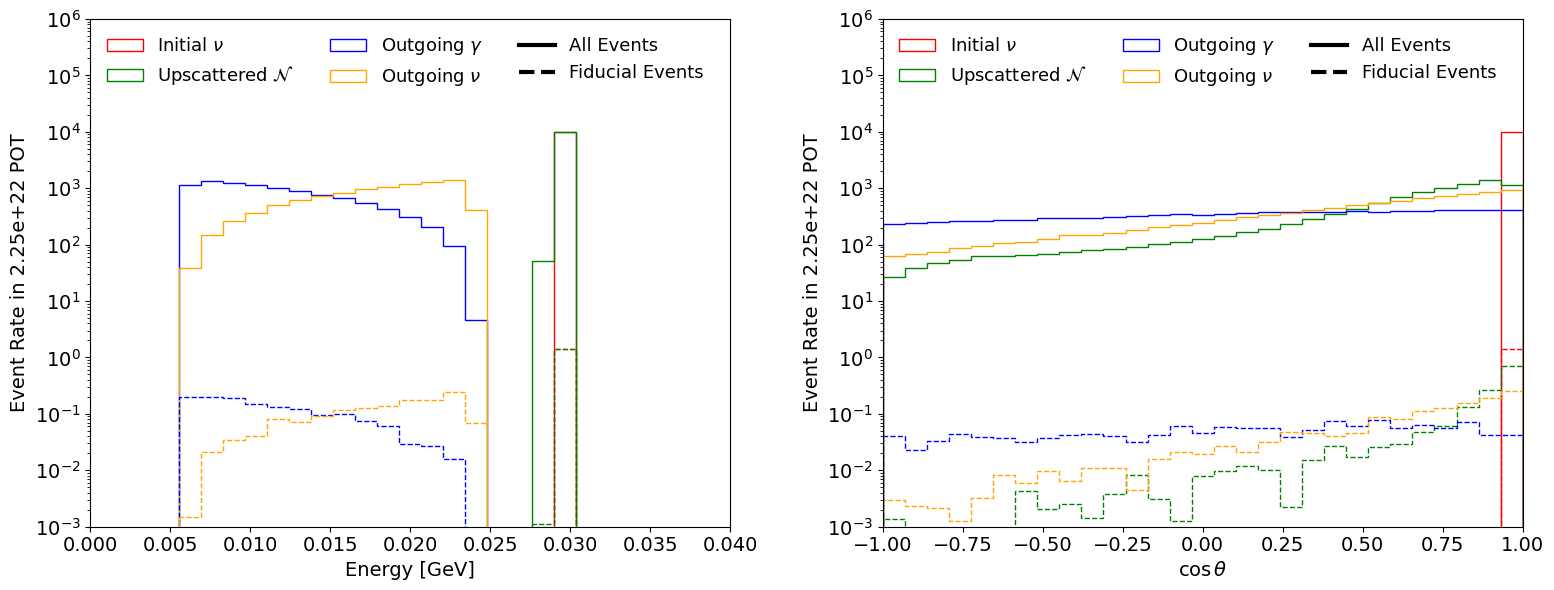

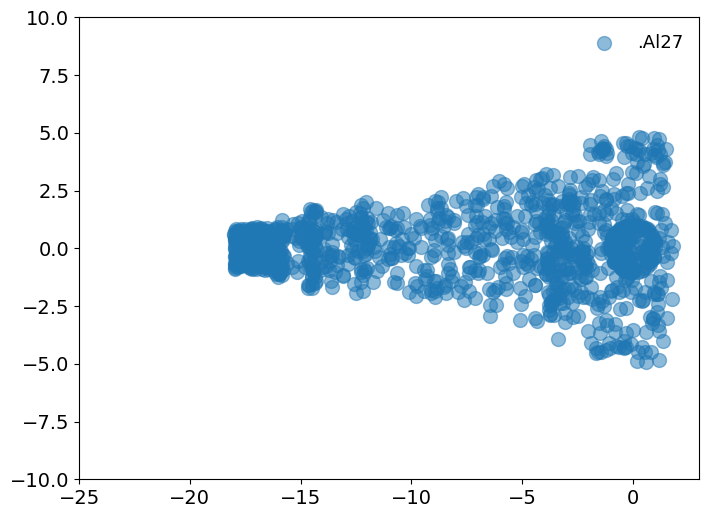

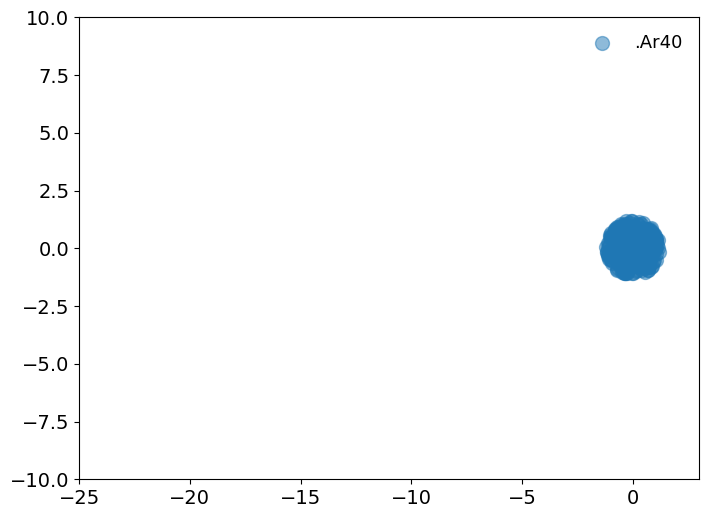

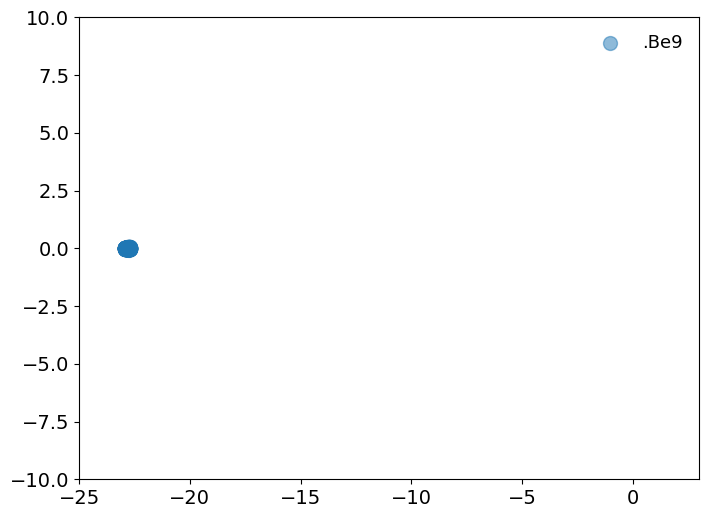

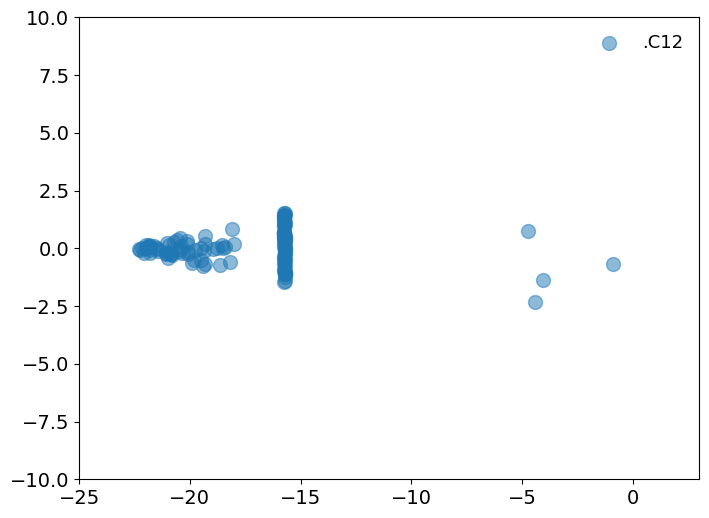

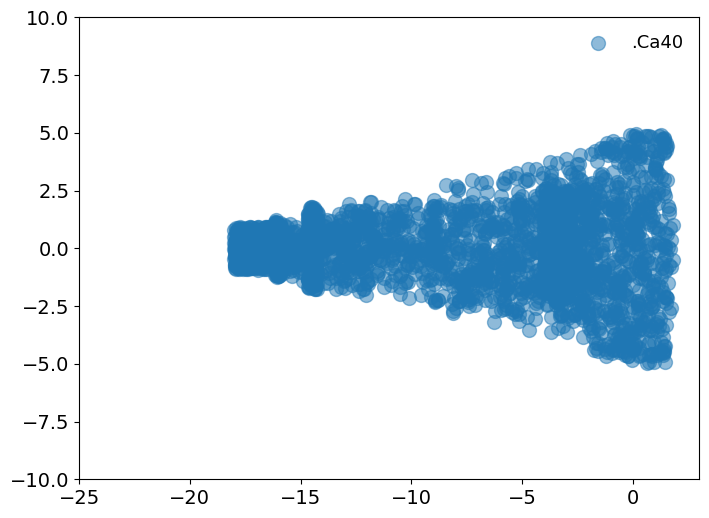

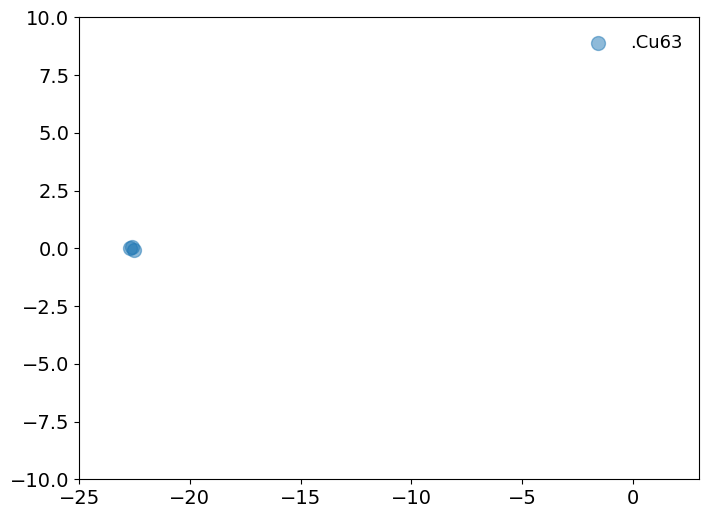

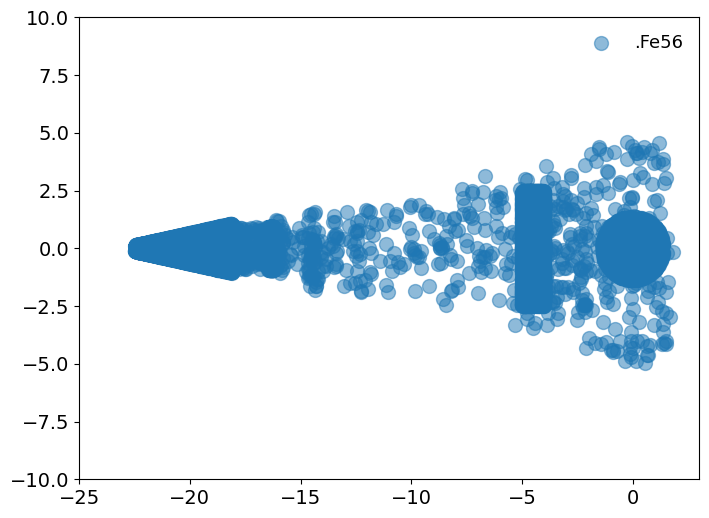

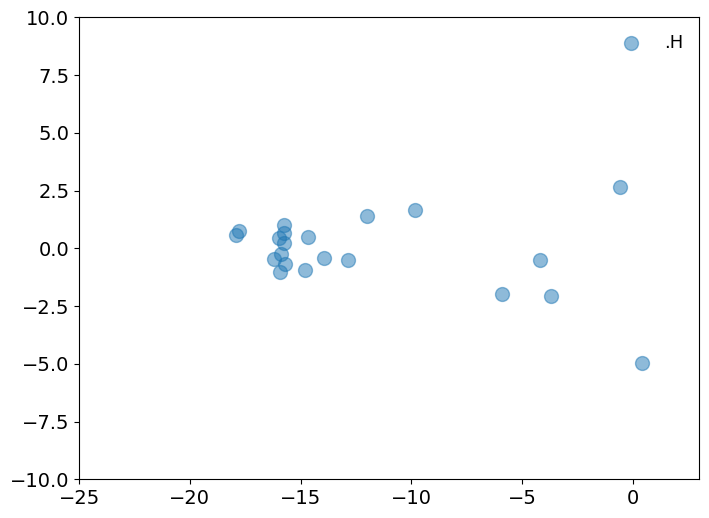

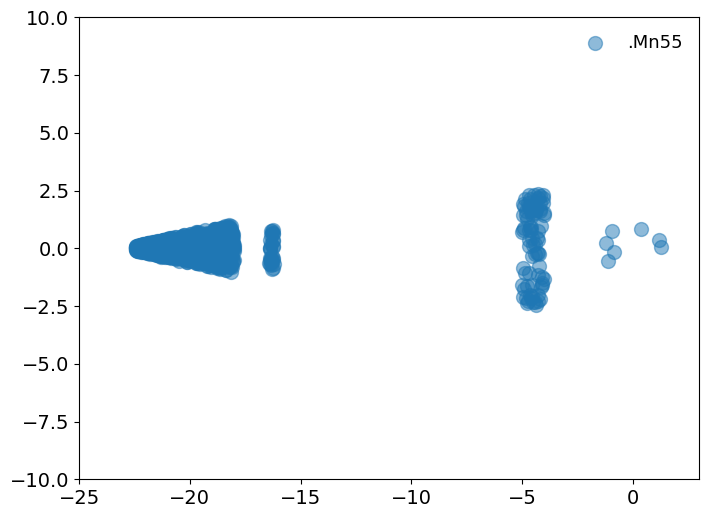

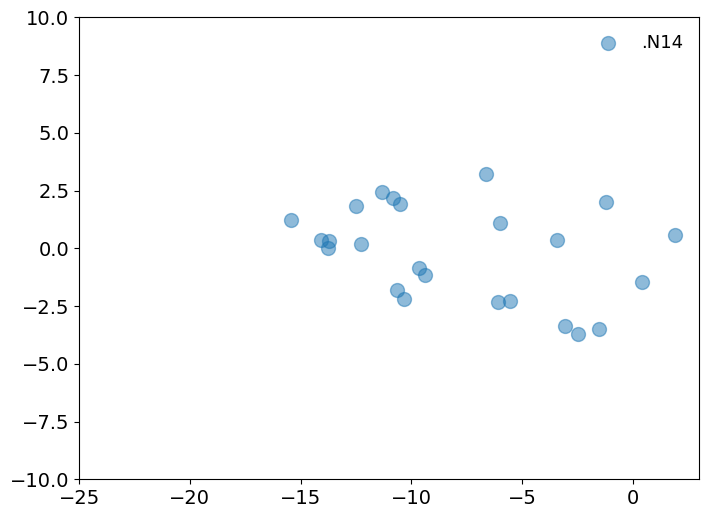

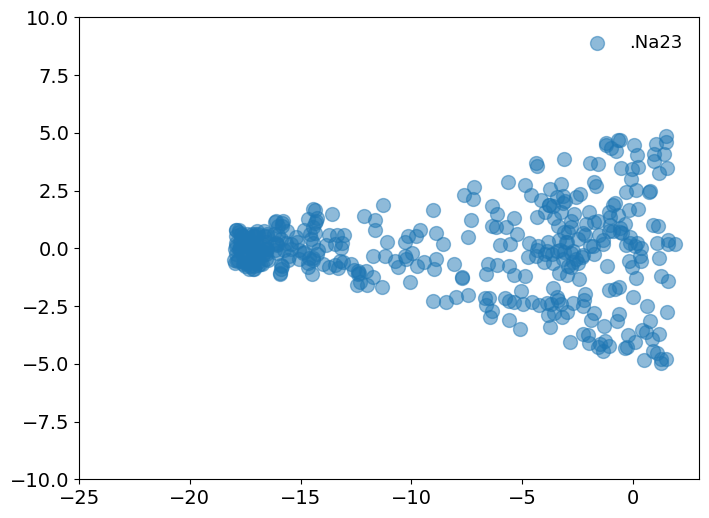

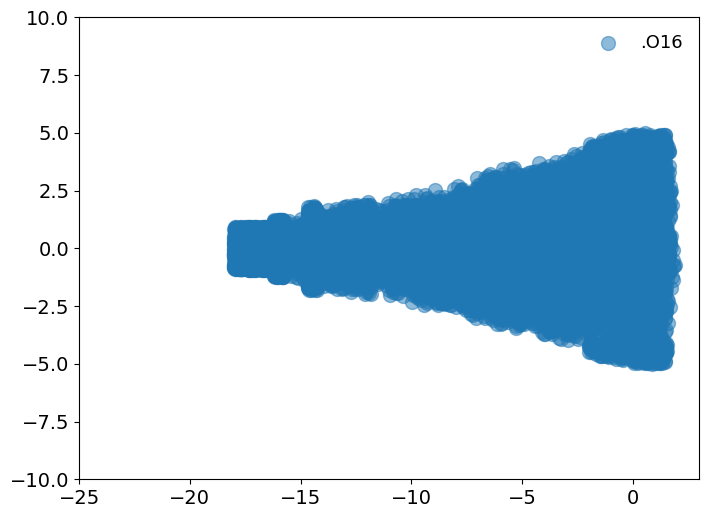

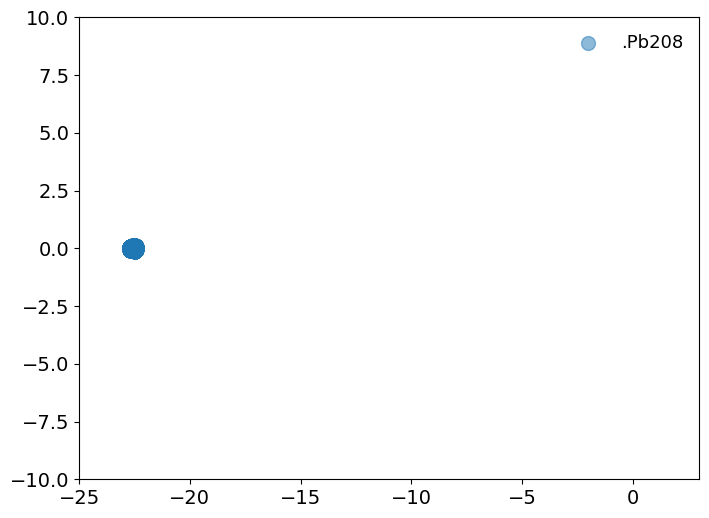

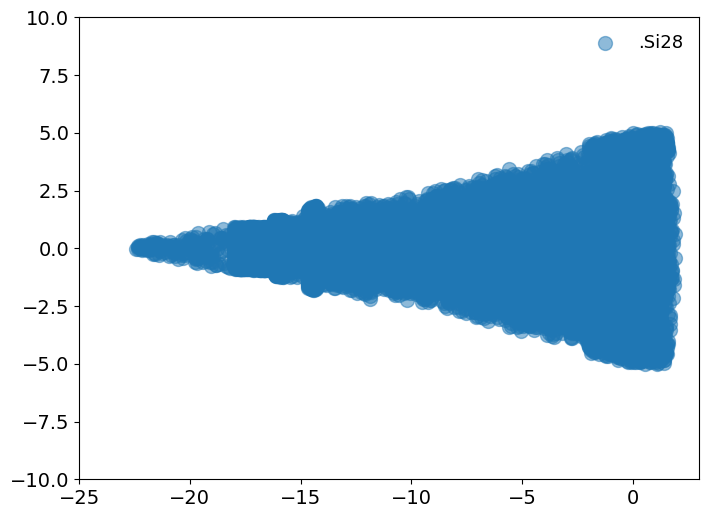

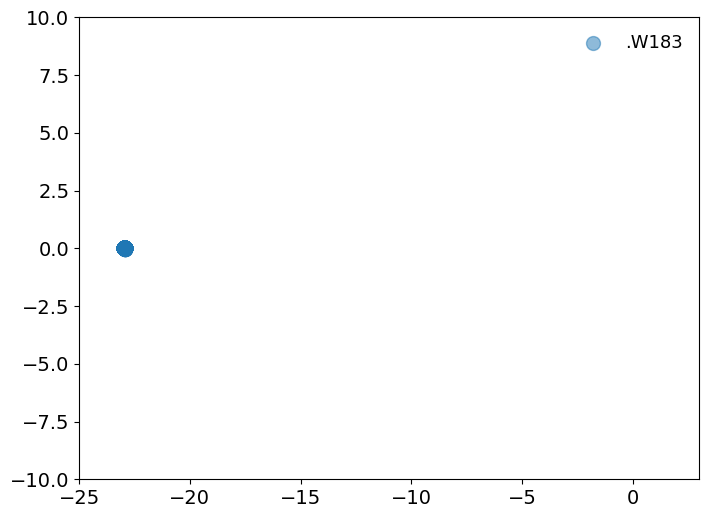

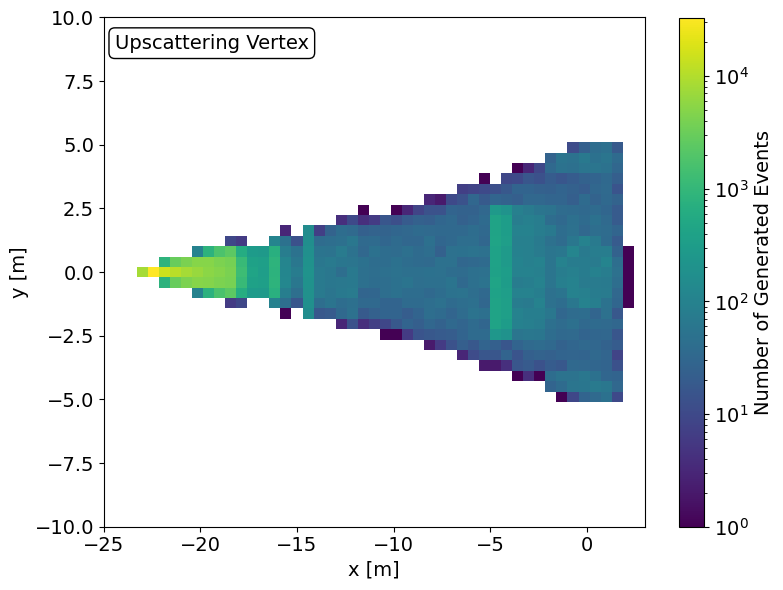

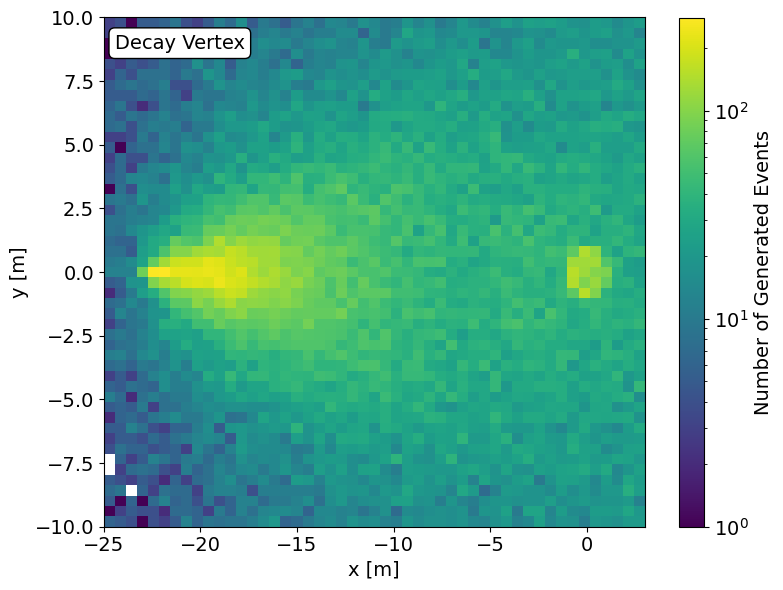

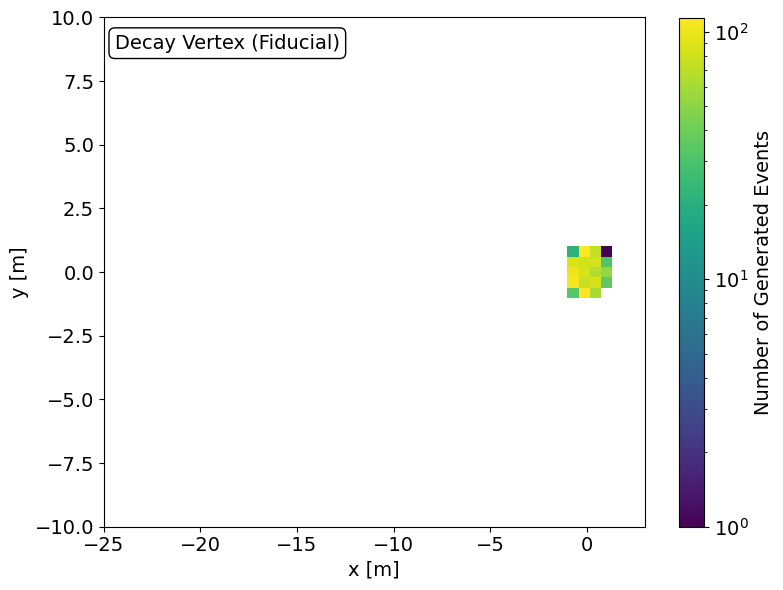

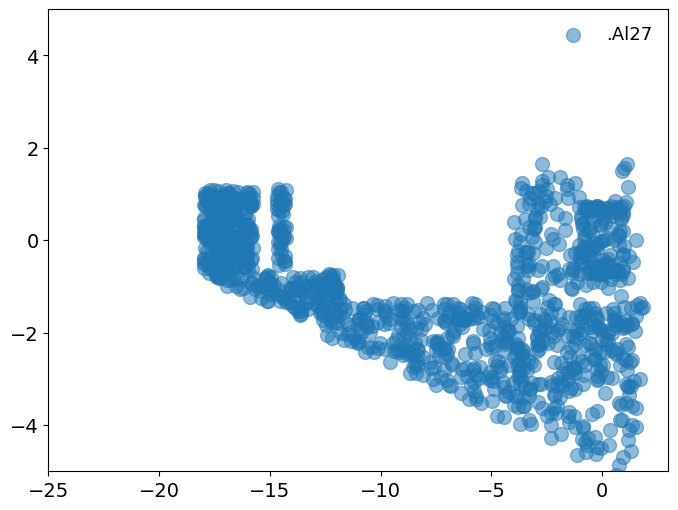

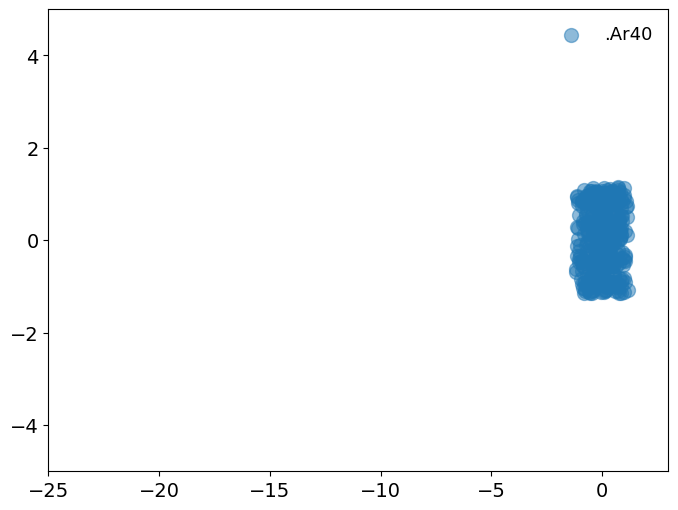

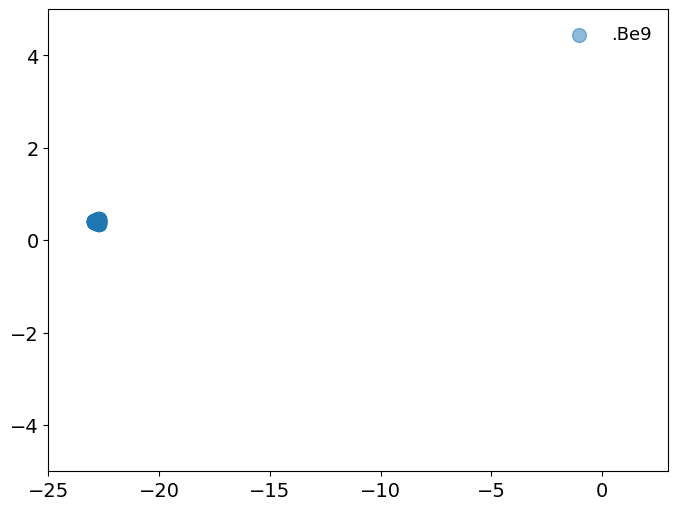

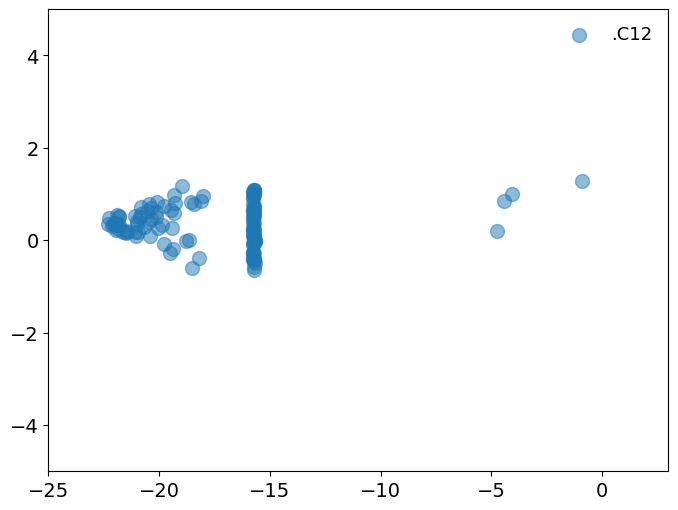

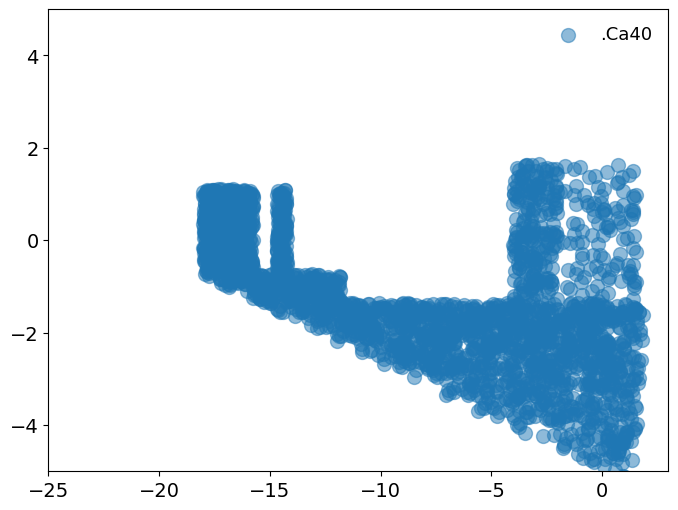

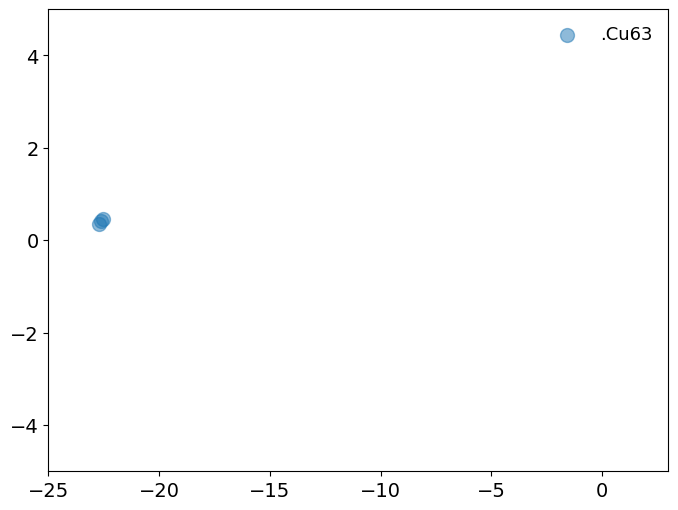

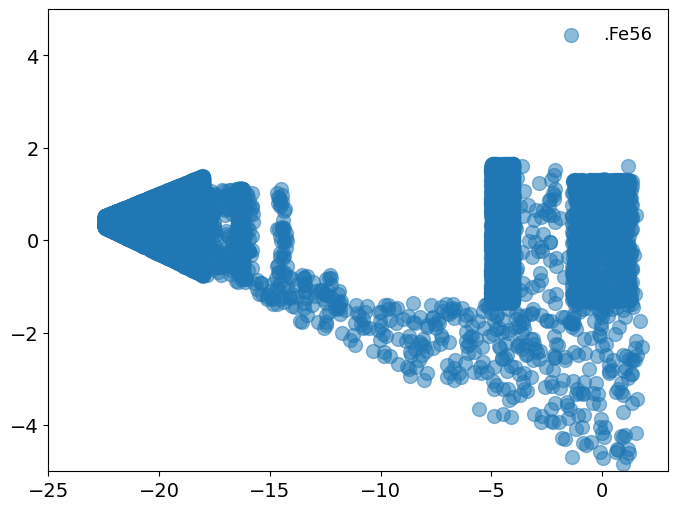

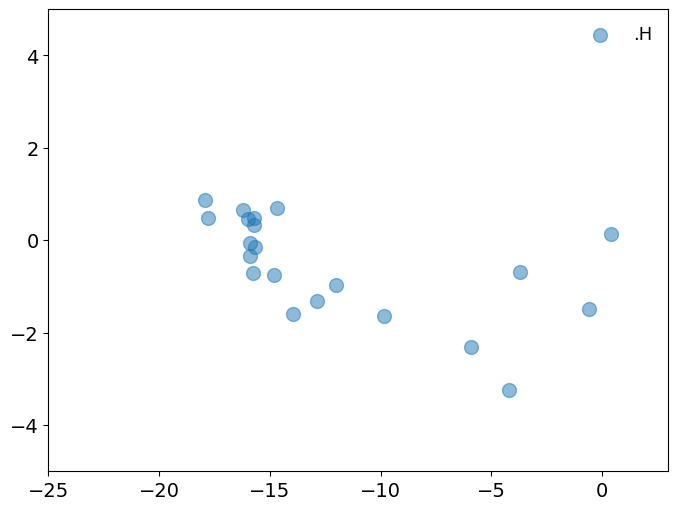

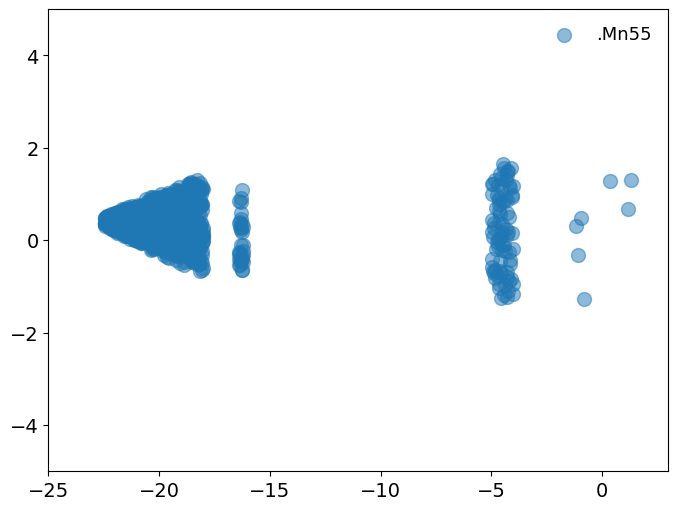

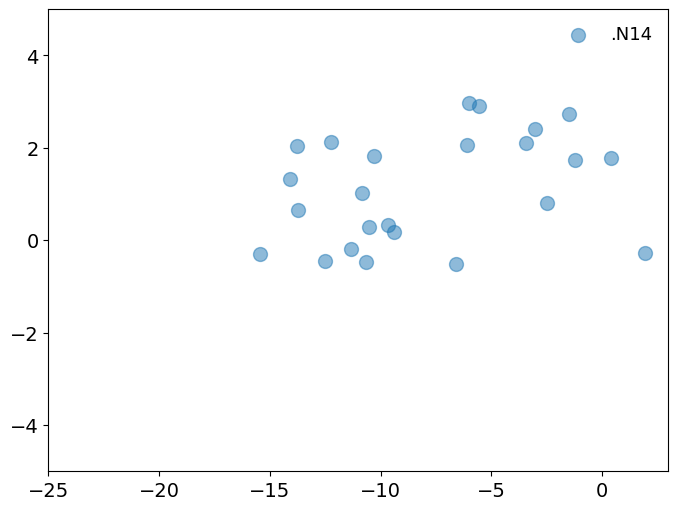

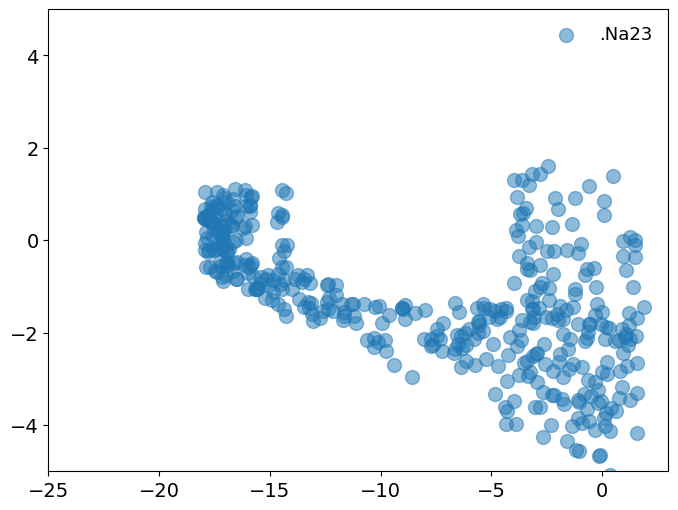

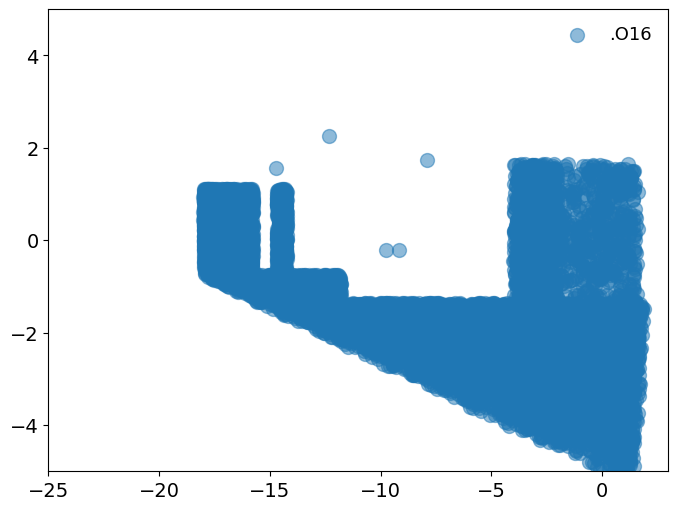

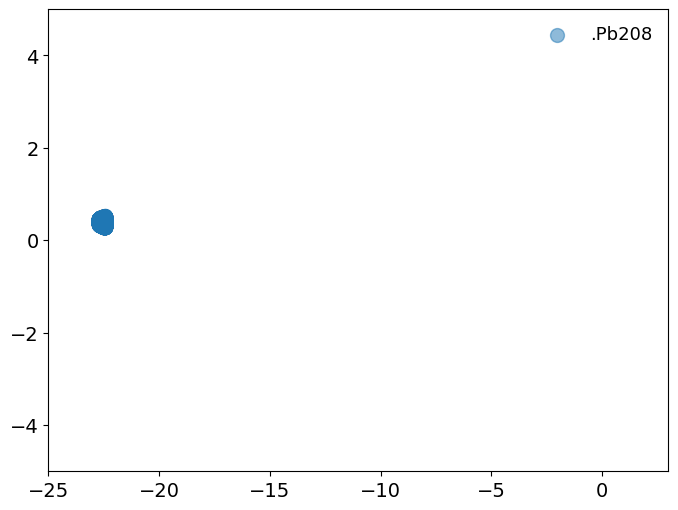

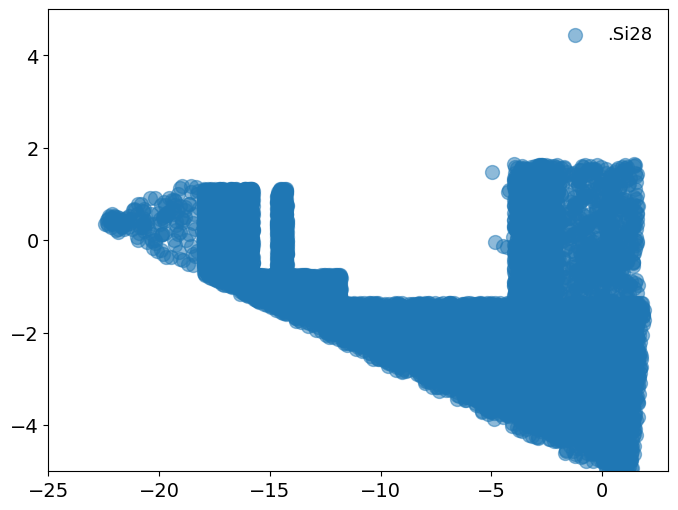

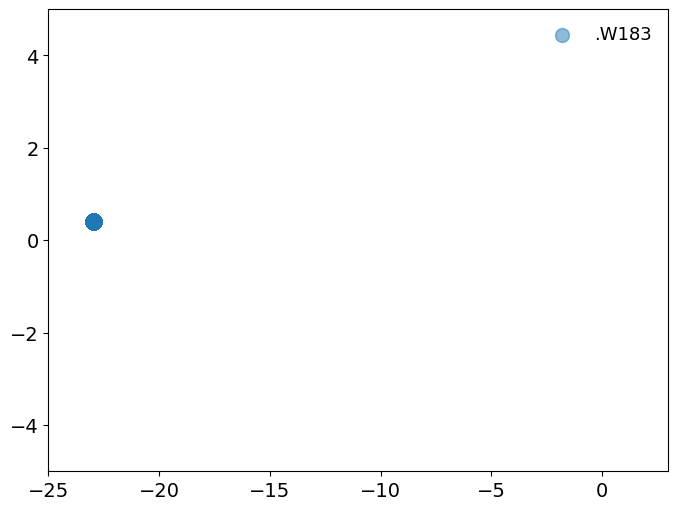

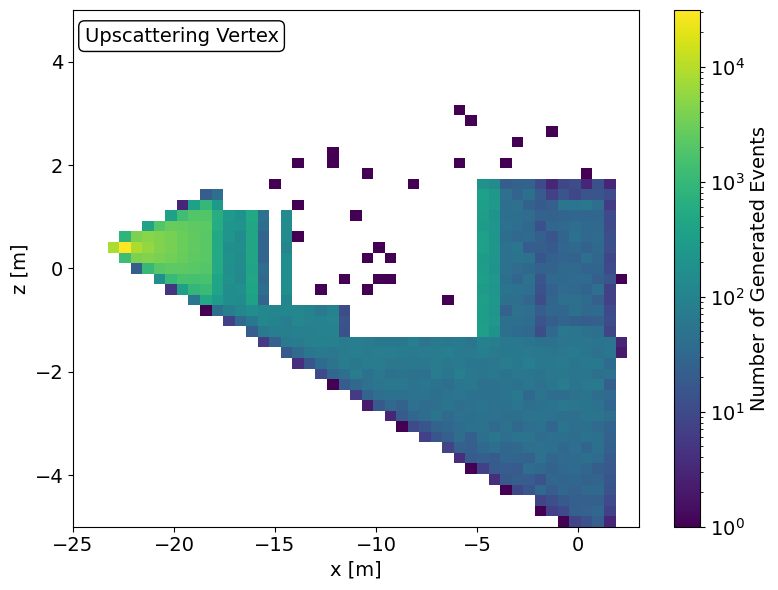

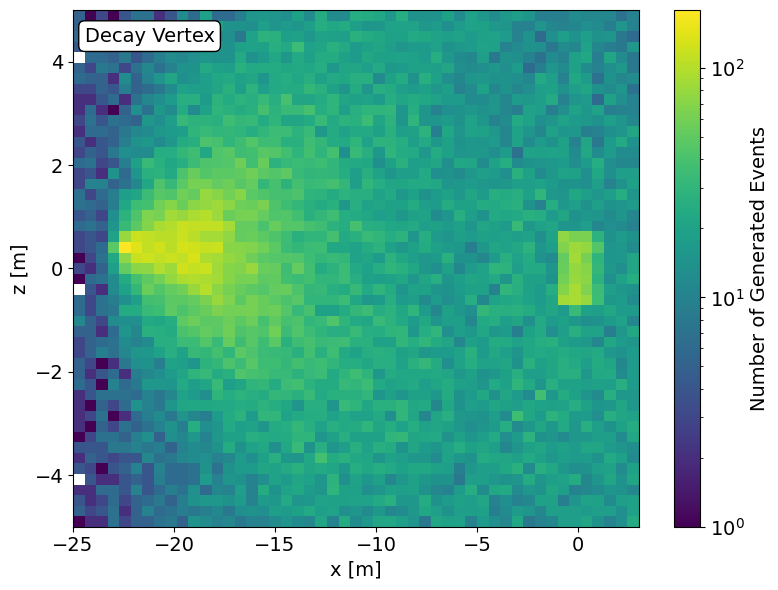

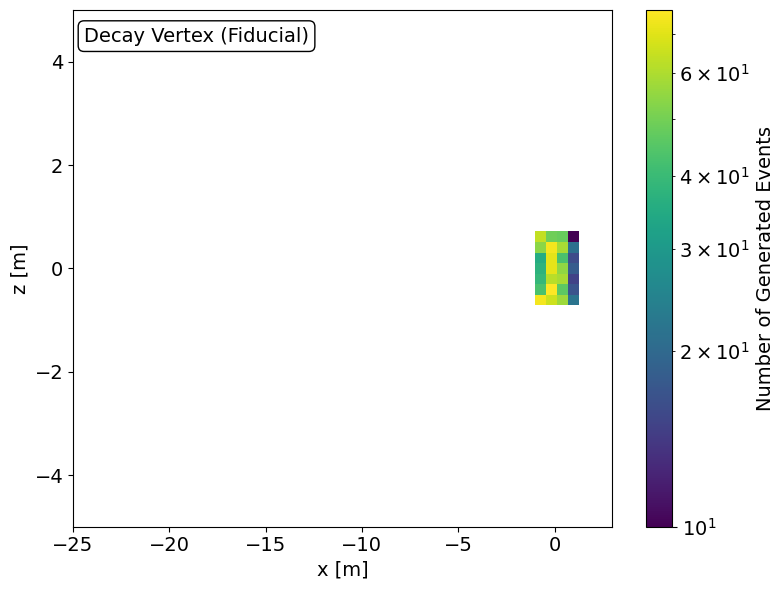

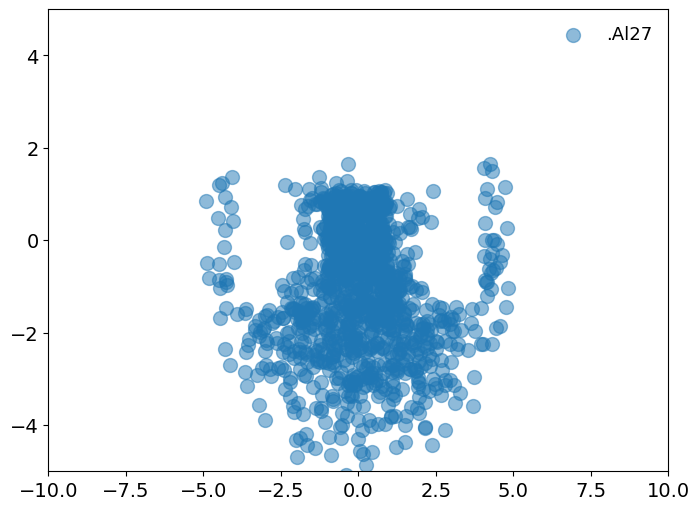

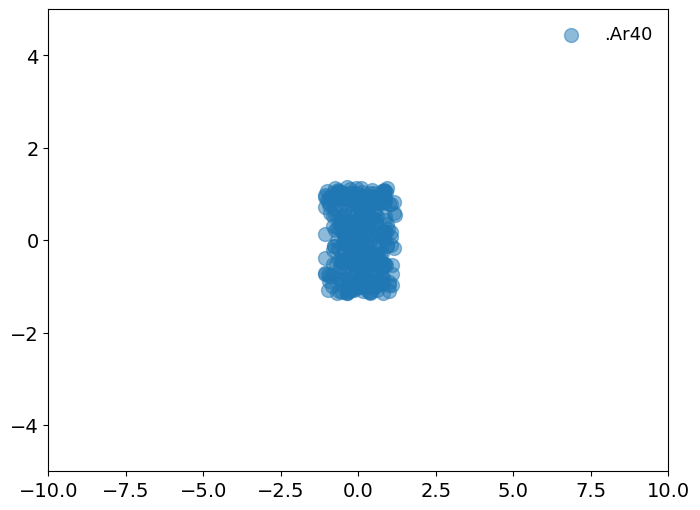

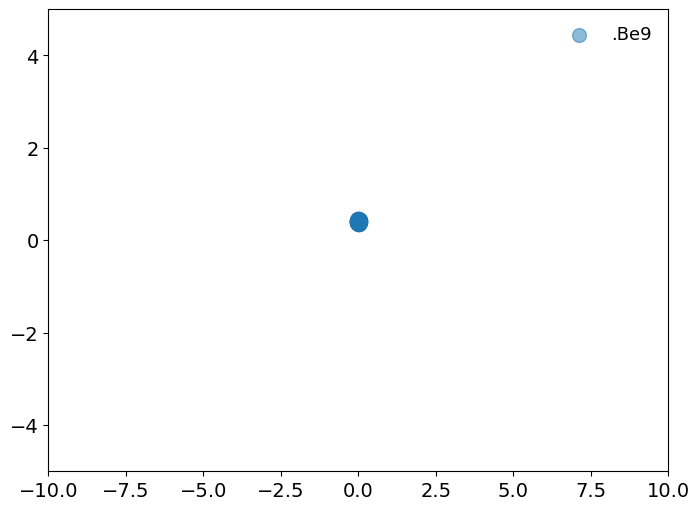

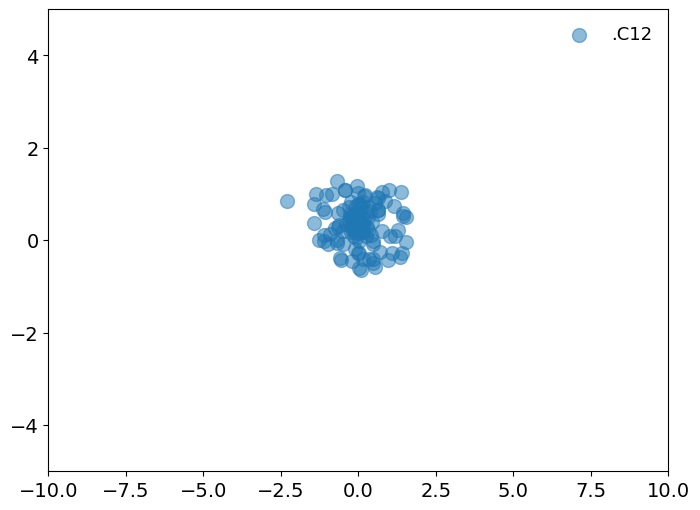

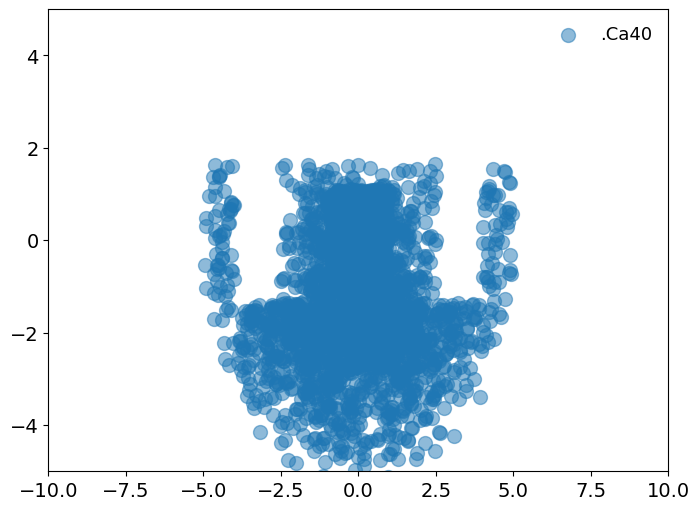

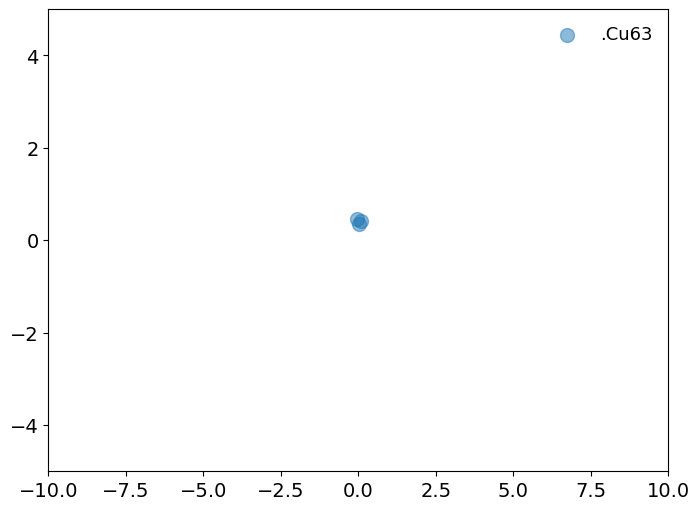

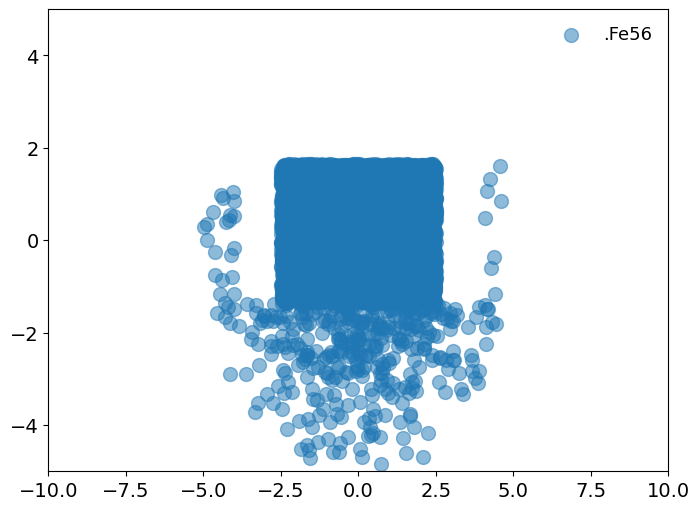

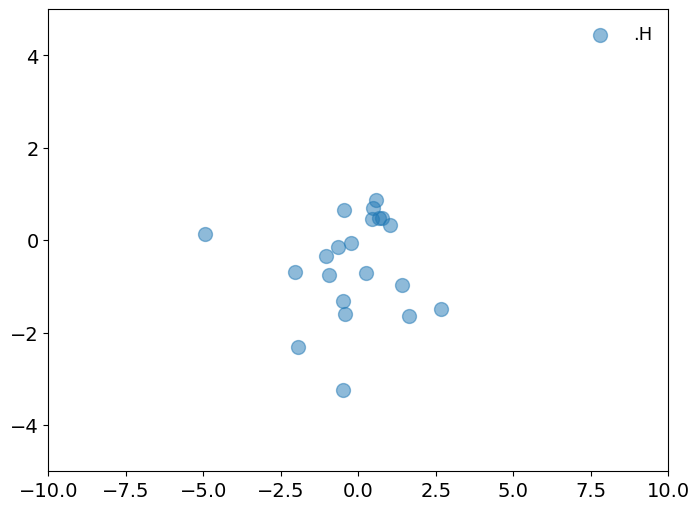

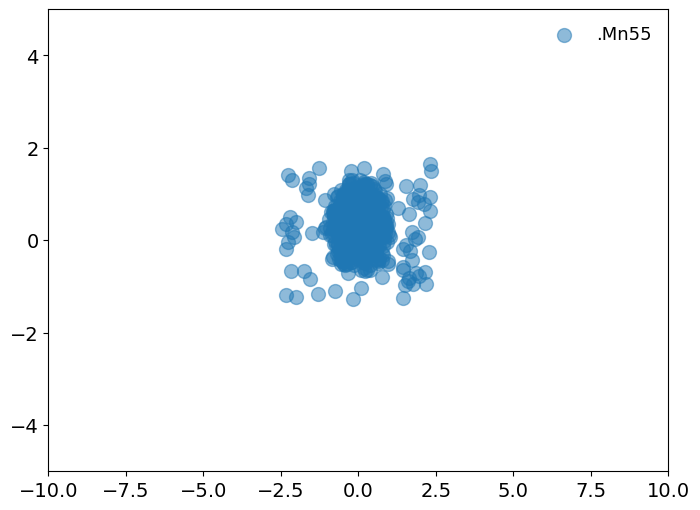

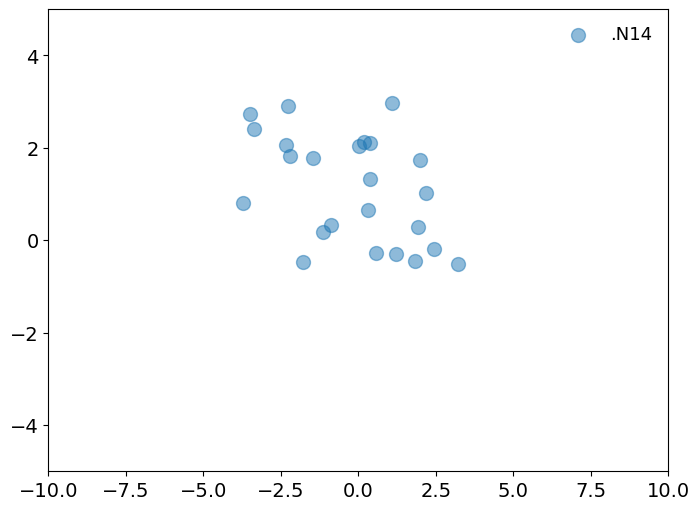

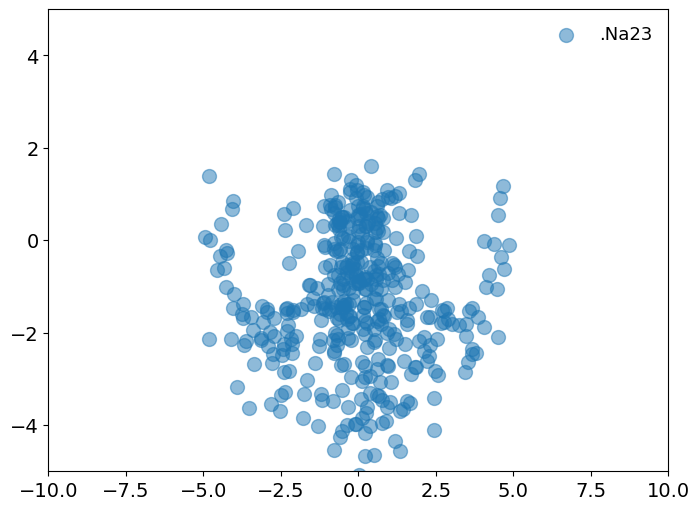

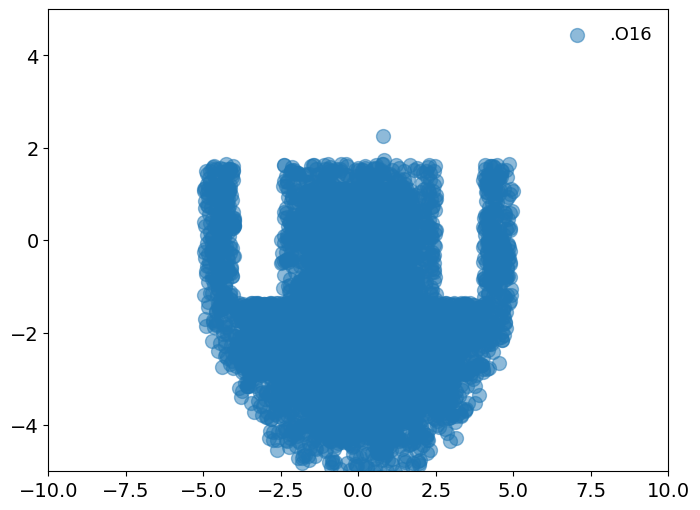

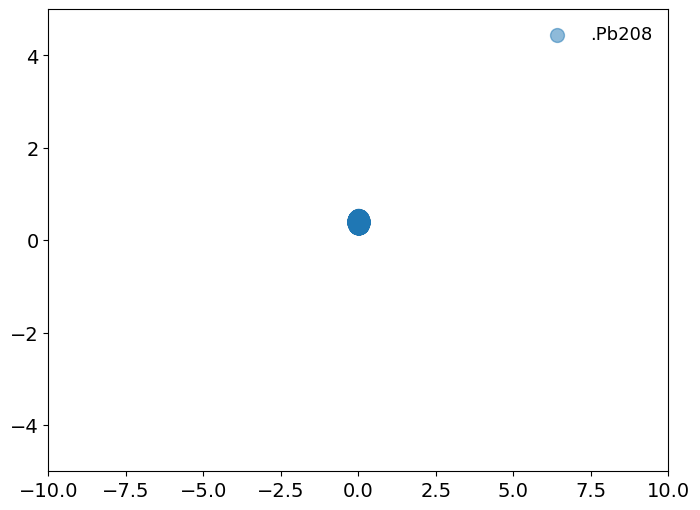

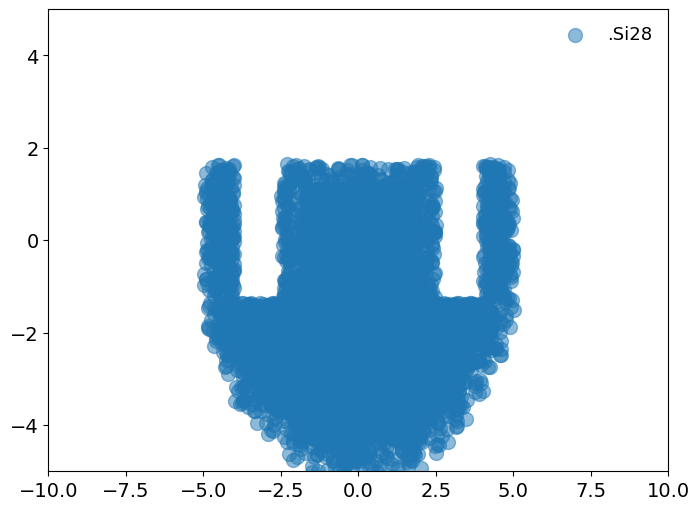

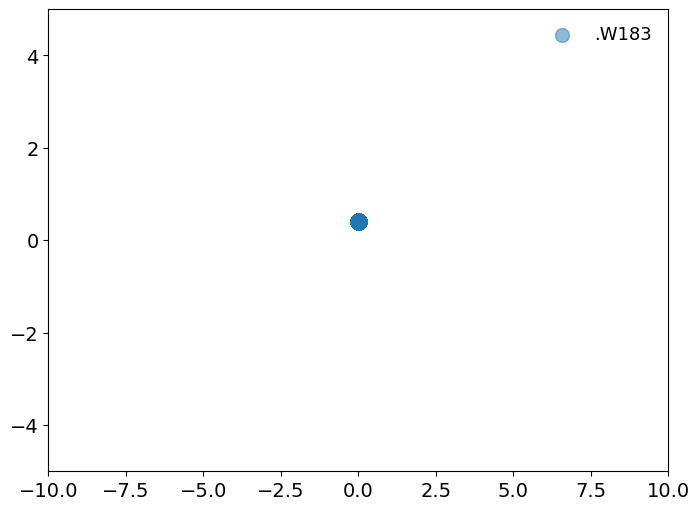

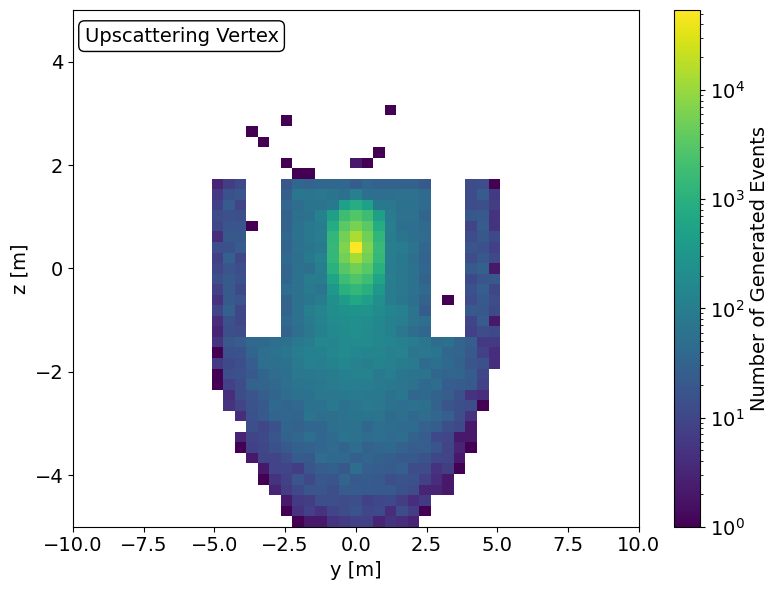

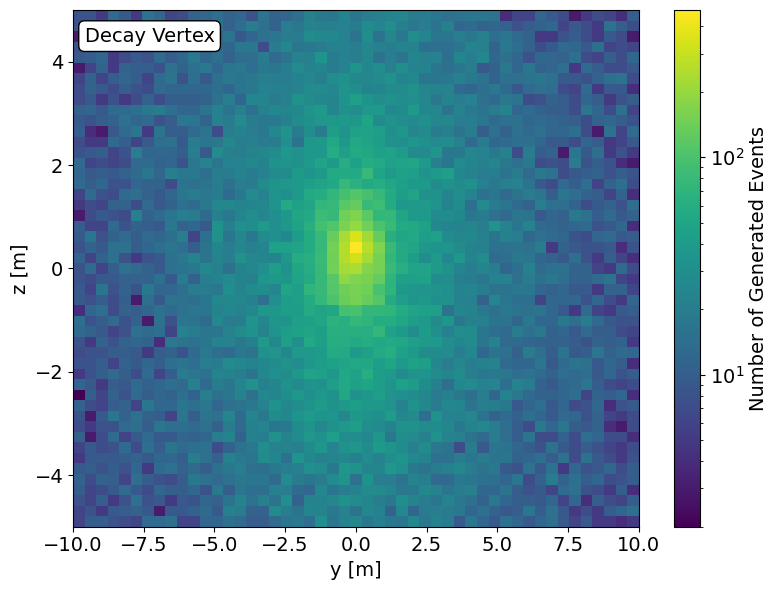

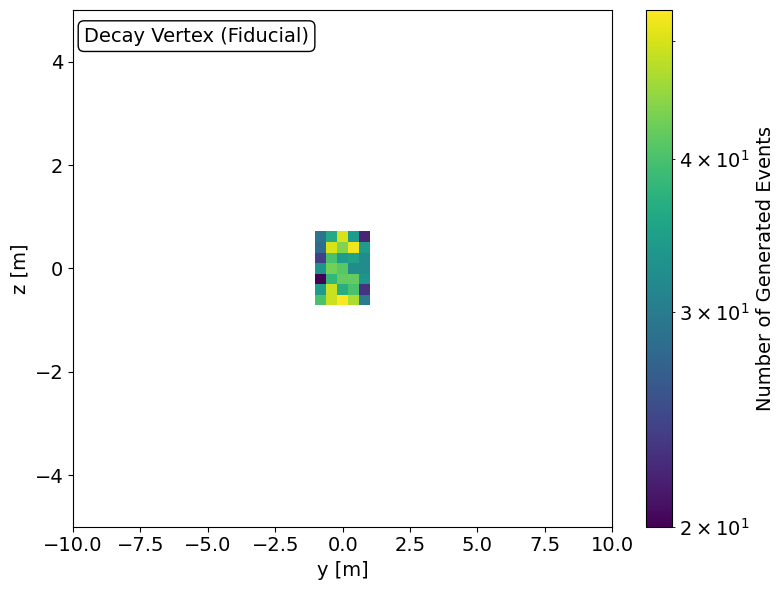

In [8]:
for k in filename.keys():
    if k!="CCM": continue
    data = awk.from_parquet("output/"+filename[k])
    plot_kinematics(data,POT[k],Emax[k],axis[k],ylim_E[k],ylim_C[k],savestr="figures/%s"%k)
    plot_positions(data,xrange[k],yrange[k],savestr="figures/%s"%k)
    if k=="CCM":
        plot_positions(data,xrange[k],zrange[k],"x","z",savestr="figures/%s"%k)
        plot_positions(data,yrange[k],zrange[k],"y","z",savestr="figures/%s"%k)
    else:
        plot_positions(data,zrange[k],yrange[k],"z","y",savestr="figures/%s"%k)
        

# Generation Time Plots

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
color = ["goldenrod","lightseagreen","mediumvioletred"]
alpha = 0.7
filename = {"MINERvA":"MINERvA_Dipole_M4.70e-01_mu1.25e-06_example.parquet",
            "MiniBooNE":"MiniBooNE_Dipole_M4.70e-01_mu1.25e-06_example.parquet",
            "CCM":"CCM_Dipole_M2.35e-02_mu3.00e-07_example.parquet"}
for c,k in zip(color,filename.keys()):
    
    #if k=="MINERvA": continue
    
    # iterative
    data = awk.from_parquet("output/iterative_tol5/"+filename[k])
    #ax[0].plot(data["event_gen_time"],color=c,alpha=alpha)
    ax[1].plot([0]+list(data["event_global_time"]),color=c,alpha=alpha)
    data = awk.from_parquet("output/iterative_tol10/"+filename[k])
    #ax[0].plot(data["event_gen_time"],ls="--",color=c,alpha=alpha)
    ax[1].plot([0]+list(data["event_global_time"]),ls="--",color=c,alpha=alpha)
    
    # precomputed
    data = awk.from_parquet("output/precomputed_tol5/"+filename[k])
    ax[0].plot([0]+list(data["event_global_time"]),label=k,color=c,alpha=alpha)
    data = awk.from_parquet("output/precomputed_tol10/"+filename[k])
    ax[0].plot([0]+list(data["event_global_time"]),ls="--",color=c,alpha=alpha)
    
ax[0].plot([],[],color="black",label="5% Interpolation Tolerance")
ax[0].plot([],[],color="black",ls="--",label="10% Interpolation Tolerance")
ax[0].set_xlabel("Generated Event Number")
ax[1].set_xlabel("Generated Event Number")
ax[0].set_ylabel("Elapsed Time [s]",labelpad=-4)
ax[1].set_ylabel("Elapsed Time [s]",labelpad=-4)
ax[0].set_ylim(0,100)
ax[1].set_ylim(0,1000)
ax[0].text(4000,1.5,"Pre-computed Cross Section Tables")
ax[1].text(2700,15,"Iteratively-generated Cross Section Tables")
ax[0].legend()
plt.savefig("figures/GenerationTiming.pdf",dpi=100)
plt.show()

# DarkNews Cross Section Checks

In [ ]:
import leptoninjector as LI
from leptoninjector.LIController import LIController
import os

# Define a DarkNews model
model_kwargs = {
    "m4": 0.47,  # 0.140,
    "mu_tr_mu4": 1.25e-6,  # 1e-6, # GeV^-1
    "UD4": 0,
    "Umu4": 0,
    "epsilon": 0.0,
    "gD": 0.0,
    "decay_product": "photon",
    "noHC": True,
    "HNLtype": "dirac",
}

# Number of events to inject
events_to_inject = 1

# number of points for cross section tables
N = 1000

experiments = ["CCM","MiniBooNE","MINERvA"]
Emaxs = [0.03,10,20]

# Expeirment to run
for experiment,Emax in zip(experiments,Emaxs):
#for experiment in ["MiniBooNE"]:  

    if experiment=="CCM":
        model_kwargs["m4"] = 0.0235
        model_kwargs["mu_tr_mu4"] = 3e-7
    else:
        model_kwargs["m4"] = 0.47
        model_kwargs["mu_tr_mu4"] = 1.25e-6
        

    # Define the controller
    controller = LIController(events_to_inject, experiment)

    # Particle to inject
    primary_type = LI.dataclasses.Particle.ParticleType.NuMu

    for tol in [10,5]:
        xs_path = "output/cross_sections_tol%s/"%str(tol)
        # Define DarkNews Model
        table_dir = os.path.join(
            xs_path,
            "Dipole_M%2.2e_mu%2.2e" % (model_kwargs["m4"], model_kwargs["mu_tr_mu4"]),
        )
        controller.InputDarkNewsModel(primary_type, table_dir, **model_kwargs)


        for xs in controller.DN_processes.cross_sections:

            int_type = xs.ups_case.nuclear_target.name+"_"+xs.ups_case.scattering_regime

            directory = "figures/DarkNewsCrossSections/%s/tol%s/%s/"%(experiment,tol,int_type)
            os.makedirs(directory,exist_ok=True)

            Erange=np.logspace(np.log10(xs.total_cross_section_table[0,0]),
                               np.log10(xs.total_cross_section_table[-1,0]),N)
            plt.scatter(xs.total_cross_section_table[:,0],xs.total_cross_section_table[:,1],
                        color="red",label="Analytic")
            plt.plot(Erange,xs.total_cross_section_interpolator(Erange),
                     ls="--",color="dodgerblue",label="Interpolated")
            plt.loglog()
            plt.xlabel(r"$E~[{\rm GeV}]$")
            plt.ylabel(r"$\sigma~[{\rm cm}^2]$")
            plt.legend(title=int_type)

            plt.savefig("%s/total.pdf"%directory,dpi=100)
            plt.clf()

            Erange=np.logspace(np.log10(xs.differential_cross_section_table[0,0]),
                               np.log10(Emax),5)#np.log10(xs.differential_cross_section_table[-1,0]),5)
            zrange=np.logspace(-6,-0.0001,N)

            for E in Erange:
                
                record = LI.dataclasses.InteractionRecord
                record.primary_momentum = [E,0,0,0]
                Q2min, Q2max = xs.Q2Min(record),xs.Q2Max(record)
                Q2 = (Q2min + (Q2max-Q2min)*zrange)

                plt.plot(Q2,xs.ups_case.diff_xsec_Q2(E,np.array(Q2)),color="red",label="Analytic")
                plt.plot(Q2,xs.differential_cross_section_interpolator(E,zrange),ls="--",color="dodgerblue",label="Interpolated")
                #plt.xlim(zrange[0],zrange[-1])
                plt.xlabel(r"$Q^2~[{\rm GeV}^2]$")
                plt.ylabel(r"$d\sigma/dQ^2~[{\rm cm}^2{\rm GeV}^{-2}]$")
                plt.legend(title="%s\n"%int_type+r"$E_\nu$ = %2.3f GeV"%(E))
                plt.loglog()
                plt.savefig("%s/differential_Enu%2.3f.pdf"%(directory,E),dpi=100)
                plt.clf()